<a href="https://colab.research.google.com/github/Akompalwad/Sentimental-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have referred [this](https://arxiv.org/pdf/1809.08651.pdf) research paper for making the model

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from nltk.stem.porter import *
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB

In [2]:
# this section is needed only if you get some error in nltk, it wouldnt hurt to
# to run it though
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train_df1 = pd.read_csv('/content/drive/My Drive/datasets/labeled_data.csv')
train_df2  = pd.read_csv('/content/drive/My Drive/datasets/train_twitter.csv')
train_df1 = train_df1[['label','tweet']]
train_df2 = train_df2[['label','tweet']]

In [4]:
train_df = pd.concat([train_df1, train_df2])
train_df.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
#This tells us about the distribution of data
train_df.label.value_counts()

0    33883
1    22862
Name: label, dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56745 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   56745 non-null  int64 
 1   tweet   56745 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


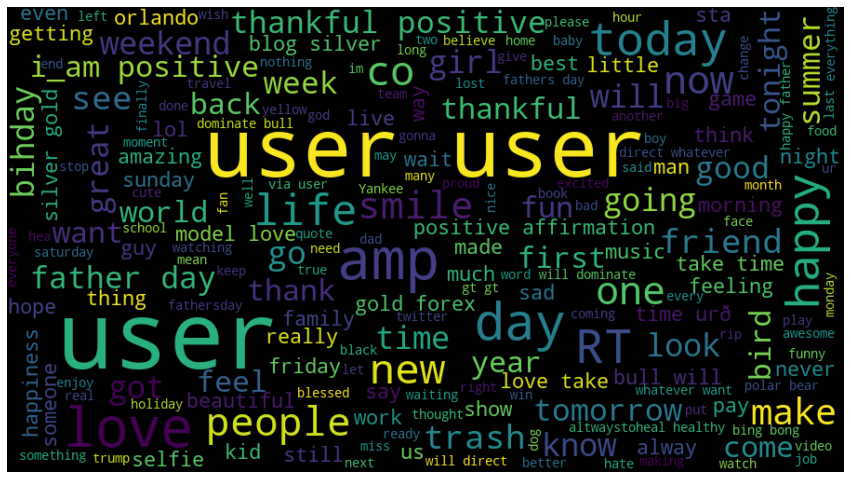

In [7]:
#lets see what words are mostly used in posts tagged as positive
nucleus_words= ' '.join([i for i in train_df['tweet'][train_df['label']==0]])
wordcloud = WordCloud(width = 900, height = 500, random_state = 21, max_font_size =100).generate(nucleus_words)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

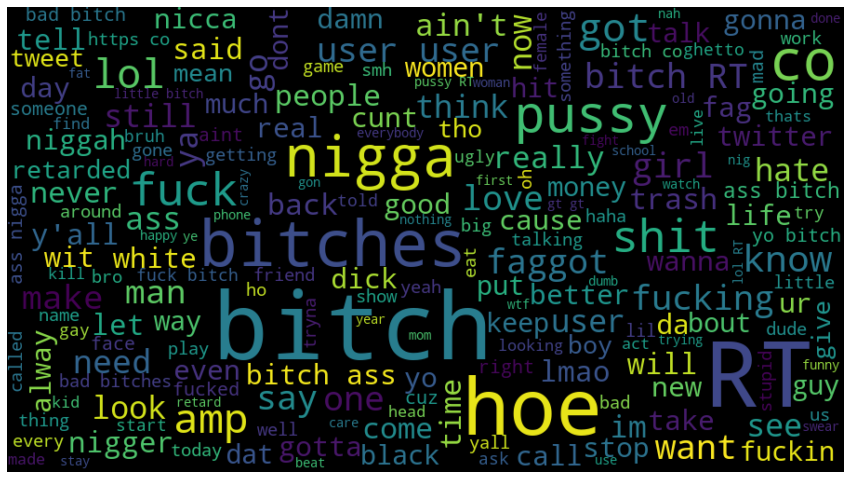

In [8]:
#for negative words
neg_words= ' '.join([i for i in train_df['tweet'][train_df['label']==1]])
wordcloud = WordCloud(width = 900, height = 500, random_state = 21, max_font_size =100).generate(neg_words)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [9]:
def clear_texts(tweet,remove_pattern):
  r = re.findall(remove_pattern,tweet)
  for i in r:
    tweet = re.sub(i,'',tweet)
  return tweet

In [10]:
#WE remove the @user handles in the data as they dont give any relevant information
train_df['tweet_n'] = np.vectorize(clear_texts)(train_df['tweet'],"@[\w]*")
#Now we remove the special characters and punctuations
train_df['tweet_n'] = train_df['tweet_n'].str.replace("[^a-zA-Z#]"," ")
#we remove words with length less than 3 as most of them are just helping verbs and dont account for important data
train_df['tweet_n'] = train_df['tweet_n'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
#make a list of tweets
train_df['tweet_n'] = train_df['tweet_n'].apply(lambda x:x.split())
#remove prefixes and suffixes from the words
stemmer = PorterStemmer()
train_df['tweet_n']= train_df['tweet_n'].apply(lambda x:[stemmer.stem(i) for i in x])
#return the list from of tweets back to string
train_df['tweet_n'] = train_df['tweet_n'].apply(lambda x:str(" ".join(i for i in x)))

In [11]:
train_df.head()

,label,tweet,tweet_n
0,0,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldn complain about clean your hous s...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,dat cold tyga cuffin place
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start confus shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear about might true might faker than bi...


In [12]:
x_train,x_test,y_train,y_test = train_test_split(train_df['tweet_n'],train_df['label'],test_size = 0.25, random_state = 42)

In [13]:
pipeline = Pipeline(
    [
     ('bow',CountVectorizer(ngram_range=(1,3))),
     ('tfidf',TfidfTransformer(norm='l2')),
     ('classifier',LogisticRegression(C=100,solver = 'liblinear')),
    ]
)
pipeline.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [14]:
predictions = pipeline.predict(x_test)

In [15]:
print(classification_report(predictions,y_test))
print ('\n')
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      8709
           1       0.89      0.93      0.91      5478

    accuracy                           0.93     14187
   macro avg       0.92      0.93      0.93     14187
weighted avg       0.93      0.93      0.93     14187



[[8091  618]
 [ 392 5086]]
0.9288080637203073


##The above model is used to make predictions about test dataset from [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/)

In [16]:
test_df = pd.read_csv(r'/content/drive/My Drive/datasets/test_tweets.csv')
test_df.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [17]:
#WE remove the @user handles in the data as they dont give any relevant information
test_df['tweet_n'] = np.vectorize(clear_texts)(test_df['tweet'],"@[\w]*")
#Now we remove the special characters and punctuations
test_df['tweet_n'] = test_df['tweet_n'].str.replace("[^a-zA-Z#]"," ")
#we remove words with length less than 3 as most of them are just helping verbs and dont account for important data
test_df['tweet_n'] = test_df['tweet_n'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
#make a list of tweets
test_df['tweet_n'] = test_df['tweet_n'].apply(lambda x:x.split())
#remove prefixes and suffixes from the words
stemmer = PorterStemmer()
test_df['tweet_n']= test_df['tweet_n'].apply(lambda x:[stemmer.stem(i) for i in x])
#return the list from of tweets back to string
test_df['tweet_n'] = test_df['tweet_n'].apply(lambda x:str(" ".join(i for i in x)))

In [18]:
test_df.head()

,id,tweet,tweet_n
0,31963,#studiolife #aislife #requires #passion #dedic...,#studiolif #aislif #requir #passion #dedic #wi...
1,31964,@user #white #supremacists want everyone to s...,#white #supremacist want everyon #bird #movi here
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal your #acn #altwaystoh #healthi #...
3,31966,is the hp and the cursed child book up for res...,curs child book reserv alreadi where when #har...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",#bihday amaz hilari #nephew ahmir uncl dave lo...


In [19]:
result = pipeline.predict(test_df['tweet_n'])
result = pd.DataFrame(result)
result.to_csv('result.csv')

##The code below this is for the api that we will be using for getting input in form of string and using our model on it

In [20]:
import pickle
pickle_file = 'sk_model.pkl'
with open(pickle_file,'wb') as file:
  pickle.dump(pipeline,file)

In [21]:
with open(pickle_file, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [22]:
def text_preprocessing(string):
  def clear_texts(tweet,remove_pattern):
    r = re.findall(remove_pattern,tweet)
    for i in r:
      tweet = re.sub(i,'',tweet)
    return tweet
  #WE remove the @user handles in the data as they dont give any relevant information
  string = np.vectorize(clear_texts)(np.array(string),"@[\w]*")
  #Now we remove the special characters and punctuations
  string= str(string).replace("[^a-zA-Z#]"," ")
  #make a list of tweets
  string = string.split()
  #we remove words with length less than 3 as most of them are just helping verbs and dont account for important data
  string = ' '.join([w for w in string if len(w)>3])
  #remove prefixes and suffixes from the words
  stemmer = PorterStemmer()
  string= [stemmer.stem(i) for i in string.split()]
  #return the list from of tweets back to string
  string = " ".join(i for i in string)
  return string

In [23]:
test_string = "Thank you @rseroter for the first ever, 10-tweet, VM to container App migration tutorial. It's that easy! (awesome job  @googlecloudteam) "

In [24]:
res = text_preprocessing(test_string)

In [25]:
res = [res]

In [26]:
Pickled_LR_Model.predict(res)
# 0 = positive tweet(non offensive, doesnt contain swear words and can be considered as neutral or positive)
# 1 = Negative Speech( community hate speech or swear words) 

array([0])